## **Time Series Forecasting**

----

Time series exist in a variety of fields from meteorology to finance, econometrics,and marketing. By recording data and analyzing it, we can study time series to ana-lyze industrial processes or track business metrics, such as sales or engagement.Also, with large amounts of data available, data scientists can apply their expertiseto techniques for time series forecasting. 

In short, a time series is simply a set of data points ordered in time.Furthermore, the data is often equally spaced in time, meaning that equal intervalsseparate each data point. In simpler terms, the data can be recorded at every hour orevery minute, or it could be averaged over every month or year. Some typical exam-ples of time series include the closing value of a particular stock, a household’s electricity consumption, or the temperature outside.

## **Importing Libraries and the data**

----

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from IPython.display import Image
import os
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
from itertools import product
from tqdm import tqdm_notebook
from typing import Union
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
print("Current Working Directory:", os.getcwd()) 

Current Working Directory: C:\Users\raimu\Desktop\New folder (2)


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesAnalysisWithPython/main/data/jj.csv')

df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [4]:
df['year'] = pd.DatetimeIndex(df['date']).year

df

,date,data,year
0,1960-01-01,0.71,1960
1,1960-04-01,0.63,1960
2,1960-07-02,0.85,1960
3,1960-10-01,0.44,1960
4,1961-01-01,0.61,1961
...,...,...,...
79,1979-10-01,9.99,1979
80,1980-01-01,16.20,1980
81,1980-04-01,14.67,1980
82,1980-07-02,16.02,1980


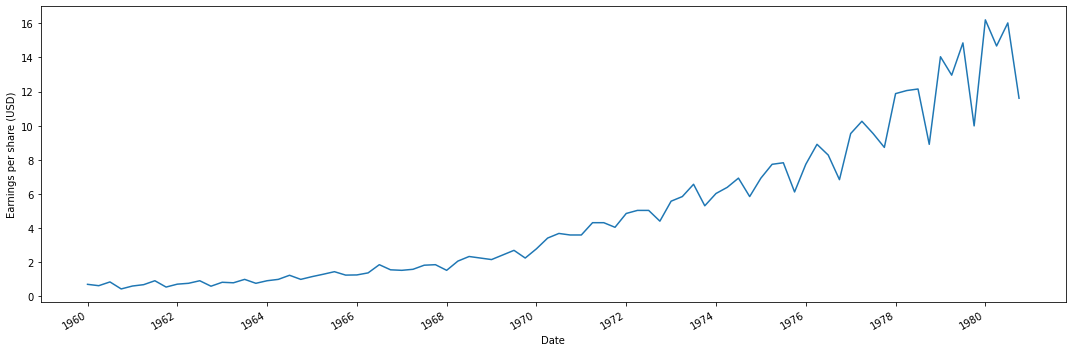

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df.date, df.data)

ax.set_xlabel('Date')

ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

As you can see, figure above clearly represents a time series. The data is indexed bytime, as marked on the horizontal axis. Also, the data is equally spaced in time, since itwas recorded at the end of every quarter of each year. We can see that the data has atrend, since the values are increasing over time. We also see the earnings going up and down over the course of each year, and the pattern repeats every year.

### **Components of a time series**

We can further our understanding of time series by looking at their three compo-nents: a trend, a seasonal component, and residuals. In fact, all time series can bedecomposed into these three elements.Visualizing the components of a time series is known as decomposition. Decomposition is defined as a statistical task that separates a time series into its different components. Using the seasonal_decompose method we have:

Period = 4 for quarterly earnings

In [6]:
advanced_decomposition = STL(df.data, period=4).fit()

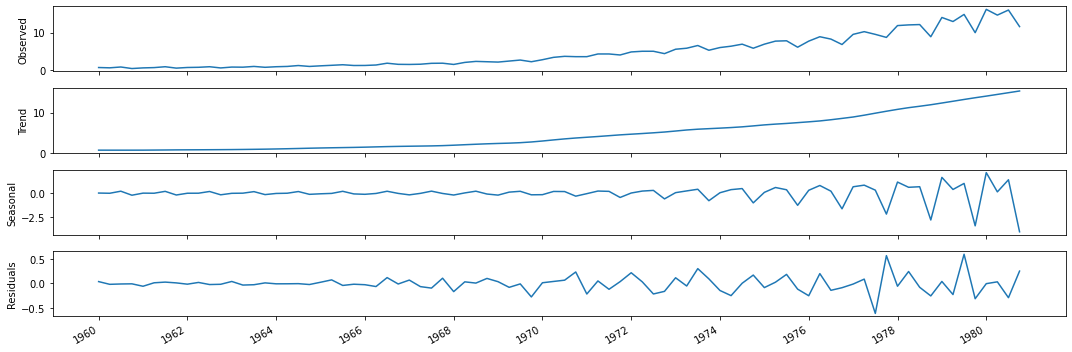

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15, 5))

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

From top to bottom we have:
    
   - First, the top graph, labeled as Observed, simply shows the time series as it was recorded;
   - Then we have the trend component defined as defined as the slow-moving changes in a time series. In this case we can see an increase overtime. Trend it is also know as level;
   - The seasonal component captures the seasonal variation, which is a cycle that occurs over a fixed period of time. In this case we see an increase in fluctuation
   - The residuals, which is what cannot beexplained by either the trend or the seasonal components. We can think of the residuals as adding the Trend and Seasonal graphs together and comparing the value at each point in time to the Observed graph. The Residuals graph shows what value must be added to Trend and Seasonal in order to adjust the result and get the same value as in Observed. Residuals usually correspond to random errors, also termed white noise represent information that we cannot model.

So in hindsight, forecasting is predicting the future using historical data and knowledge of futureevents that might affect our forecasts. This definition is full of promises and, as data scientists, we are often very eager to start forecasting by using our scientific knowledge to showcase an incredible model with a near-perfect forecast accuracy. However, there are important steps that must be covered before reaching the point of forecasting.

The first concept to keep in mind is that time series have an order, and we cannot change that order when modeling. In time series forecasting, we express future values as a function of past values. Therefore, we must keep the data in order, so as to not violate this relationship.

So how do we make predictions??

**Lets import some stock data**

In [8]:
data = yf.download("GOOG", start="2010-01-01", end = "2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [9]:
data = data["Close"]

In [10]:
data.head()

Date
2010-01-04 00:00:00-05:00    15.610239
2010-01-05 00:00:00-05:00    15.541497
2010-01-06 00:00:00-05:00    15.149715
2010-01-07 00:00:00-05:00    14.797037
2010-01-08 00:00:00-05:00    14.994298
Name: Close, dtype: float64

For this exercise I am going to model a random walk. A random walk is a process in which there is an equal chance of going up or down by arandom number. This is usually observed in financial and economic data, like the daily closing price of GOOGL. Random walks often expose long periods where a positive or negative trend can be observed. They are also often accompanied by sudden changes in direction as seen bellow.

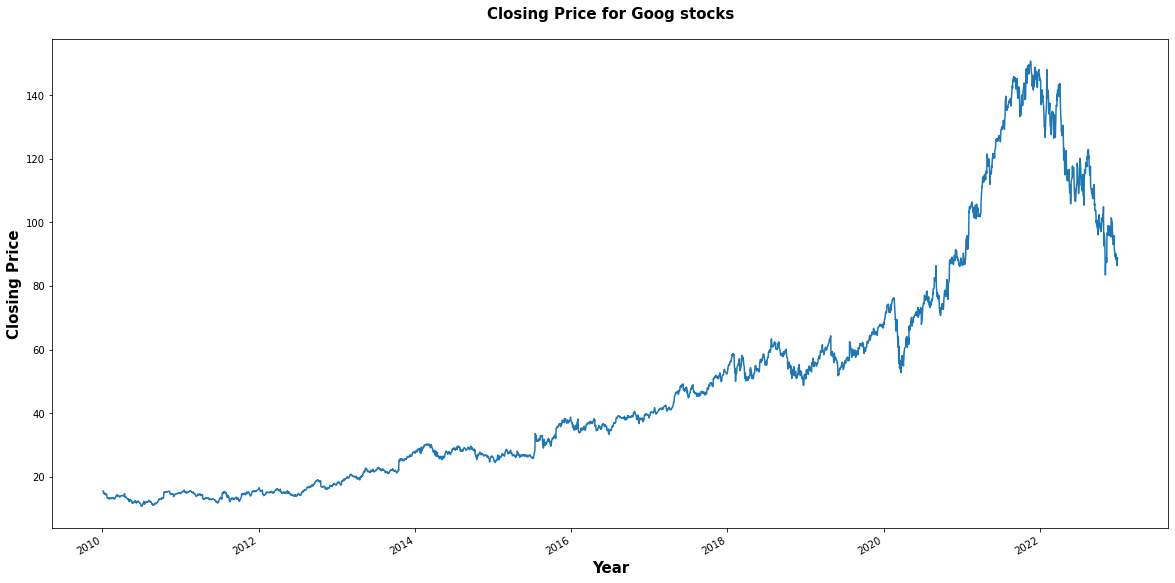

In [11]:
plt.figure(figsize = (20, 10))

data.plot()

plt.title("Closing Price for Goog stocks", loc ="center", pad = 20, fontsize = 15, fontweight = "bold")
plt.xlabel("Year", fontsize=15, weight = 'bold')
plt.ylabel("Closing Price", fontsize=15, weight = 'bold')

plt.show()

In a random walk process, we say that the present value yt is a function of the valueat the previous timestep yt –1, a constant C, and a random number εt, also termed white noise. Here, εt is the realization of the standard normal distribution, which has a variance of 1 and a mean of 0. Therefore, we can mathematically express a random walk with the following equation, where y t is the value at the present time t, C is a constant, yt –1 is the value at the previous timestep t–1, and εt is a random number:

yt = C + yt–1 + εt 

Note that if the constant C is nonzero, we designate this process as a random walk with drift.

So how do we model a random walk? For simplicity sake let's assume that C = 0

In [12]:
np.random.seed(42) ## This seed is to ensure that each time we run the code the same data points are always produced

steps = np.random.standard_normal(1000) ## We generate 1000 data points with normal distribution

steps[0]=0 ## We start here at moment 0

random_walk = np.cumsum(steps) ## We then assume continuous steps. Each step will consist of the sum with the previous noise so y1 = εt1, y2 = εt1 + εt2 ...

Plotting the data

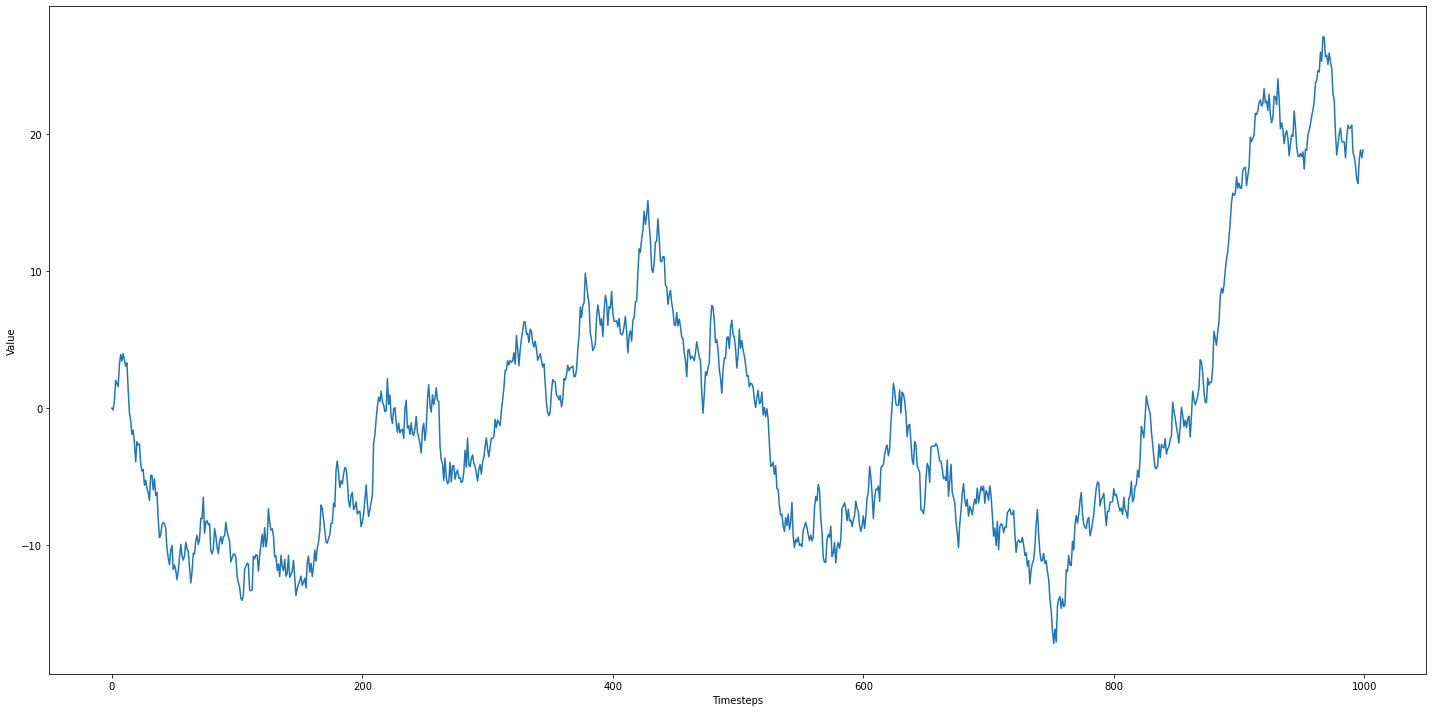

In [13]:
fig, ax = plt.subplots(figsize = (20, 10))

ax.plot(random_walk)

ax.set_xlabel('Timesteps')

ax.set_ylabel('Value')

plt.tight_layout()

By initializing our random walk process at 0 and setting the constant C to 0, we determine that the value at time t is simply the sum of white noise from t = 1 to time t. Thus, our simulated random walk will respect the equation 3.6, where yt is the value of the random walk process at time t, and εt is a random number at time t. We know this is a random walk because we simulated it. However, when dealingwith real-life data, we need to find a way to identify whether our time series is a random walk or not. Let’s see how we can achieve this:

**Random walk: A random walk is a series whose first difference is stationary and uncorrelated. This means that the process moves completely at random.**

## **Stationarity**

A stationary time series is one whose statistical properties do not change over time. In other words, it has a constant mean, variance, and autocorrelation, and these properties are independent of time. For now, since we are still in the early stages of time series forecasting, we’ll focus on stationary time series, which means that we will need to find ways to transform our time series to make them stationary. A transformation is simply a mathematical manipulation of the data that stabilizes its mean and variance, thus making it stationary.The simplest transformation one can apply is differencing. This transformation helps stabilize the mean, which in turn removes or reduces the trend and seasonality effects. Differencing involves calculating the series of changes from one timestep to another.

**Differencing: y't = yt - yt-1**

While differencing is used to obtain a constant mean through time, we must also make sure we have a constant variance in order for our process to be stationary. Logarithms are used to help stabilize the variance. Transformation in time series forecasting. A transformation is a mathematical operation applied to a time series in order to make it stationary. Differencing is a transformation that calculates the change from one timestep to  another. This transformation is useful for stabilizing the mean. Applying a log function to the series can stabilize its variance. Keep in mind that when we model a time series that has been transformed, we must untransform it to return the results of the model to the original units of measurement. The formal term for undoing a transformation is inverse transform. Therefore, if you apply a log transformation to your data, make sure you raise your forecast values to the power of 10 in order to bring the values back to their original magnitude. That way, your predictions will make sense in their original context.

Once a transformation is applied to a time series, we need to test for stationarity to determine if we need to apply another transformation to make the time series stationary, or if we need to transform it at all. A common test is the augmented Dickey-Fuller (ADF) test. The ADF test verifies the following null hypothesis: there is a unit root present in a time series. The alternative hypothesis is that there is no unit root, and therefore the time series is stationary. The result of this test is the ADF statistic, which is a negative number. The more negative it is, the stronger the rejection of the null hypothesis. In its implementation in Python, the p-value is also returned. If its value is less than 0.05, we can also reject the null hypothesis and say the series is stationary.

## **Auto Correlation**

Once a process is stationary, plotting the autocorrelation function (ACF) is a great way to understand what type of process you are analyzing. In this case, we will use it to determine if we are studying a random walk or not. The ACF reveals how the correlation between any two values changes as the lag increases. Here, the lag is simply the number of timesteps separating two values. So putting it all together:

In [14]:
ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.965952487691875
p-value: 0.7654789696692581


A p-value greater than 0.05, we cannot reject the null hypothesis stating that our time series is not stationary. We can further support our conclusion by plotting the ACF function:

<Figure size 1440x720 with 0 Axes>

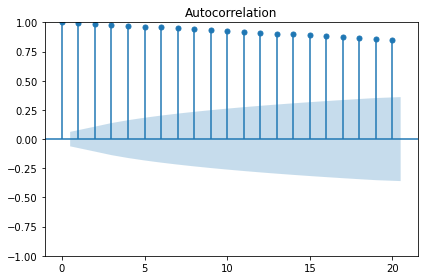

In [15]:
plt.figure(figsize = (20, 10))

plot_acf(random_walk, lags=20);

plt.tight_layout()

You’ll notice how the autocorrelation coefficients slowly decrease as the lag increases, which is a clear indicator that our random walk is not a stationary process. Note that the shaded area represents a confidence interval. If a point is within the shaded area, then it is not significantly different from 0. Otherwise, the autocorrelation coefficient is significant. Because our random walk is not stationary, we need to apply a transformation to make it stationary in order to retrieve useful information from the ACF plot. Since our sequence mostly displays changes in the trend without seasonal patterns, we will apply a first-order differencing. Remember that we’ll lose the first data point every time we difference.

In [16]:
diff_random_walk = np.diff(random_walk, n=1)

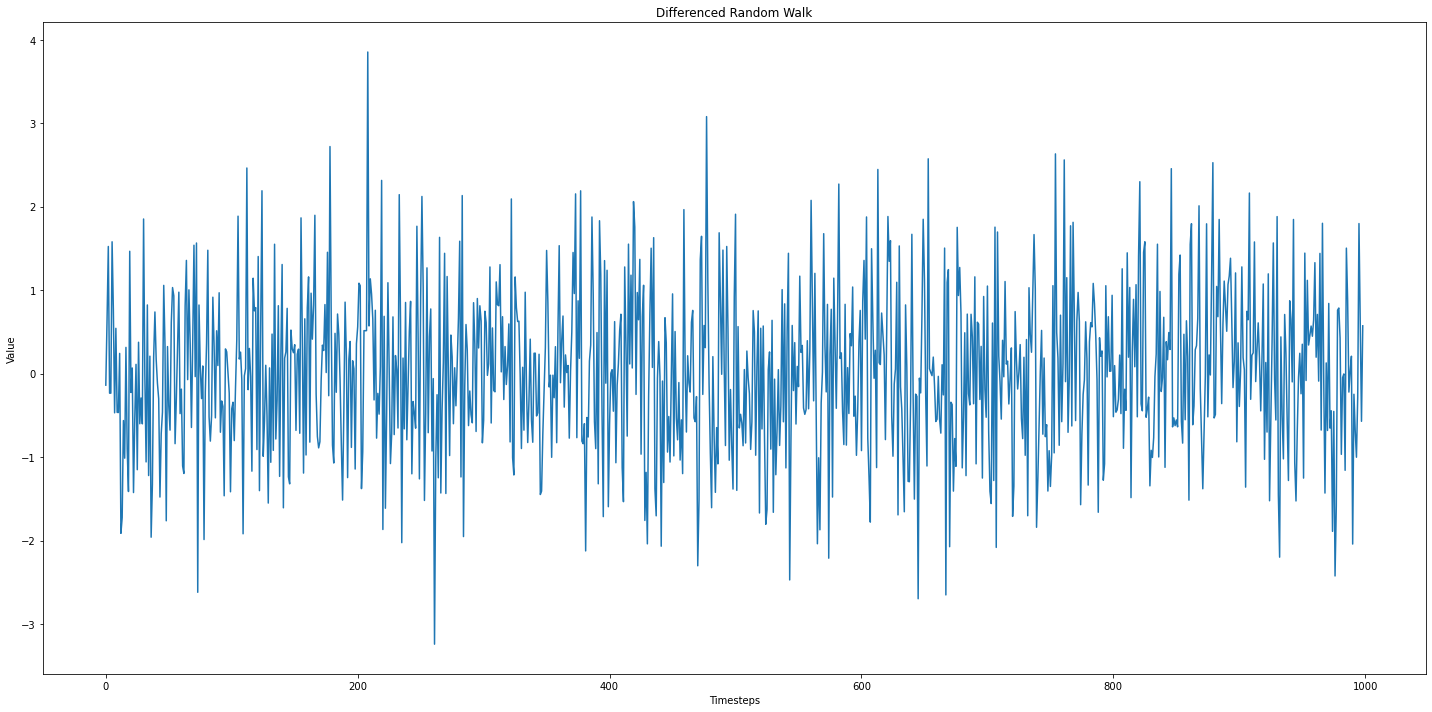

In [17]:
plt.figure(figsize = (20, 10))

plt.plot(diff_random_walk)

plt.title('Differenced Random Walk')

plt.xlabel('Timesteps')

plt.ylabel('Value')

plt.tight_layout()

In [18]:
ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -31.789310857560615
p-value: 0.0


This prints out an ADF statistic of –31.79 with a p-value of 0. This time the ADF statistic is a large negative number, and the p-value is less than 0.05. Therefore, we reject the null hypothesis, and we can say that this process has no unit root and is thus stationary.

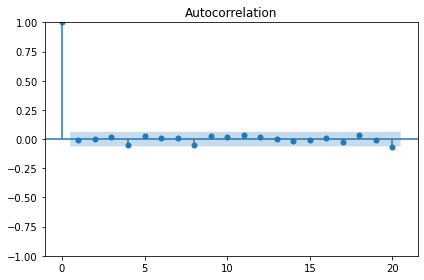

In [19]:
plot_acf(diff_random_walk, lags=20);

plt.tight_layout()

There are no significant autocorrelations after lag 0. This means that the stationary process is completely random and can therefore be described as white noise. Each value is simply a random step away from the previous one, with no relation between them. Let-s know check GOOG data

In [20]:
GOOGL_ADF_result = adfuller(data)

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: -0.5780248458627547
p-value: 0.8758706013155413


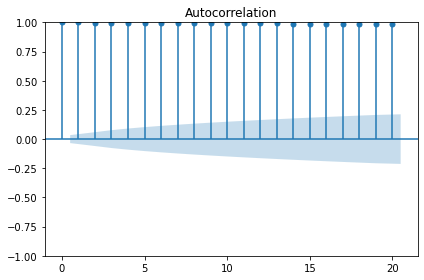

In [21]:
plot_acf(data, lags=20)

plt.tight_layout()

From the results differencing is required!

In [22]:
diff_close = np.diff(data, n=1)

In [23]:
GOOGL_ADF_result = adfuller(diff_close)

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: -13.186287343540757
p-value: 1.1683514931325548e-24


The series now is stationary. Looking at the acf plot:

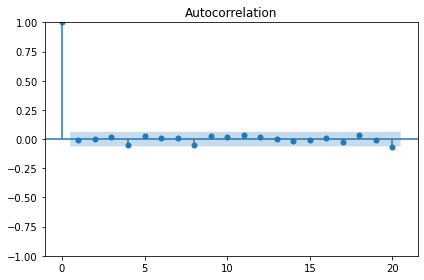

In [24]:
plot_acf(diff_random_walk, lags=20);

plt.tight_layout()

There are no significant autocorrelations after lag 0. This means that the stationary process is completely random and can therefore be described as white noise.

## **Making Predictions**

#### **Autoregressive Integrated Moving Average Process**

Just like the ARMA process, the ARIMA process states that the present value is dependent on past values, coming from the AR(p) portion, and past errors, coming from the MA(q) portion. However, instead of using the original series, denoted as yt, the ARIMA process uses the differenced series, denoted as y't. Note that y't can repre- sent a series that has been differenced more than once. Therefore, the mathematical expression of the ARIMA(p,d,q) process states that the present value of the differenced series y't is equal to the sum of a constant C, past values of the differenced series φpy't–p, the mean of the differenced series μ, past error terms θqεt–q, and a current error term εt.

y't = C + φ1y't –1 +⋅⋅⋅ φpy't–p + θ1ε't –1 +⋅⋅⋅+ θqε't –q + εt 

Just like in the ARMA process, the order p determines how many lagged values of the series are included in the model, while the order q determines how many lagged error terms are included in the model. However, you’ll notice that there is no order d explicitly displayed. Here, the order d is defined as the order of integration. Integration is simply the reverse of differencing. The order of integration is thus equal to the number of times a series has been differenced to become stationary. If we difference a series once and it becomes stationary, then d = 1. If a series is differenced twice to become stationary, then d = 2.

In [25]:
df = pd.read_csv(r'C:\Users\raimu\Desktop\New folder (2)\bandwidth.csv')

df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


Now that we’ve defined the autoregressive moving average process and seen how the orders p and q affect the model’s equation, we need to determine how to identify such an underlying process in a given time series

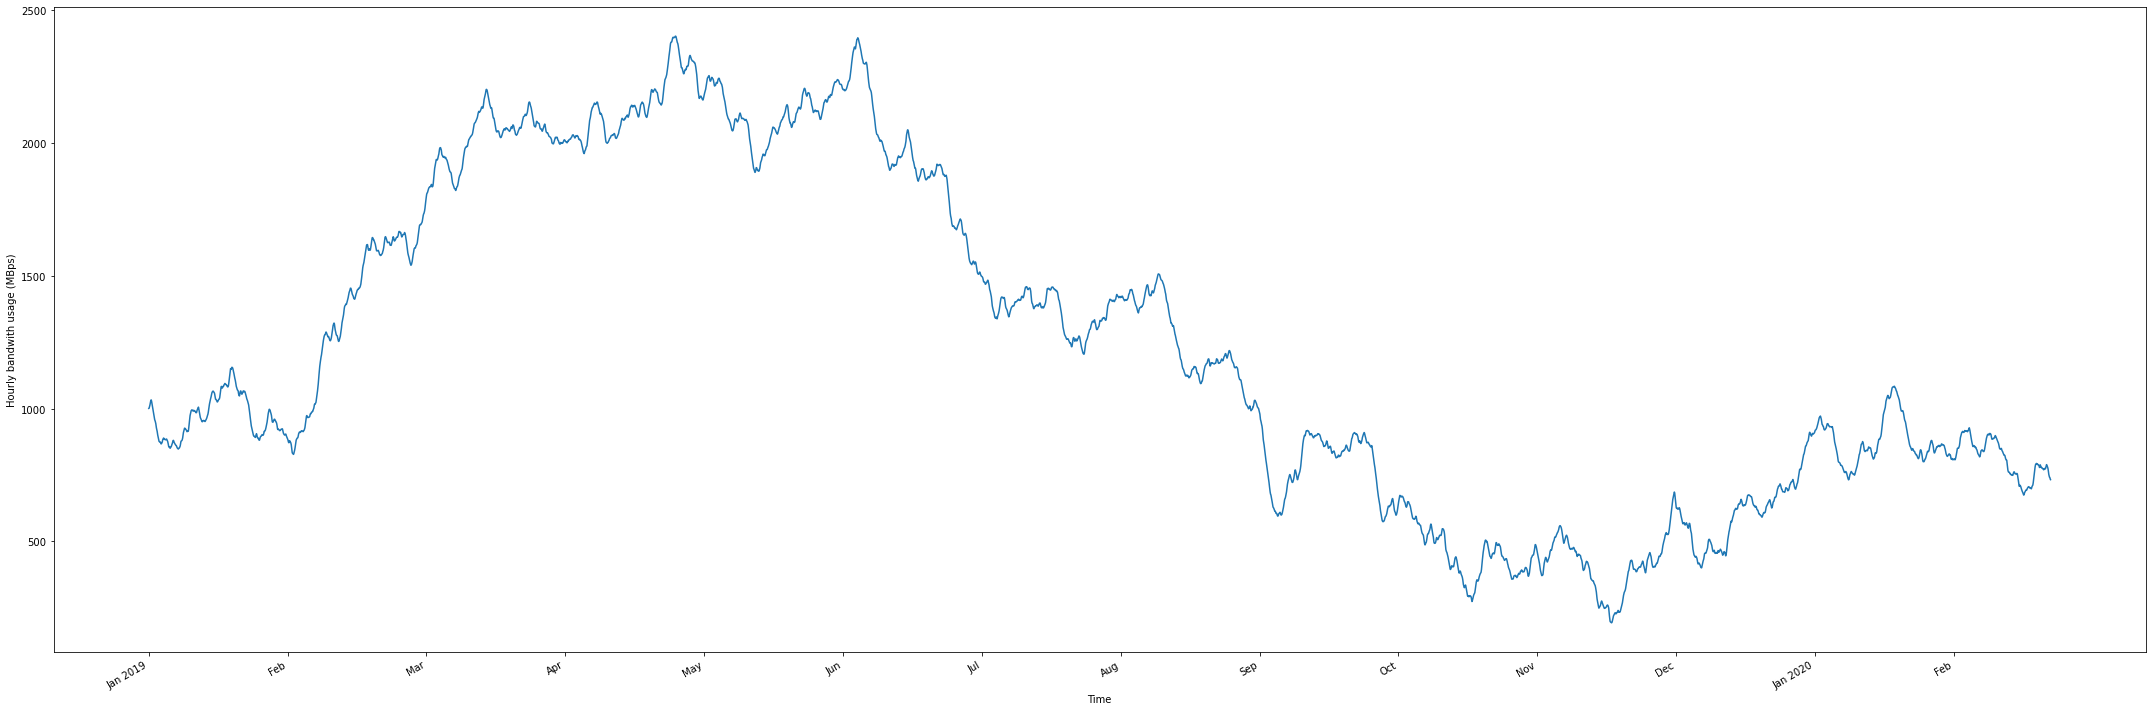

In [26]:
fig, ax = plt.subplots(figsize = (30,10))

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

The next step is to check for stationarity. As mentioned before, the presence of a trend means that our series is likely non-stationary. Let’s verify that using the ADF test.

In [27]:
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199452776
p-value: 0.7972240255014538


From the ADF the series is not stationary! So first order difference is applied

In [28]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

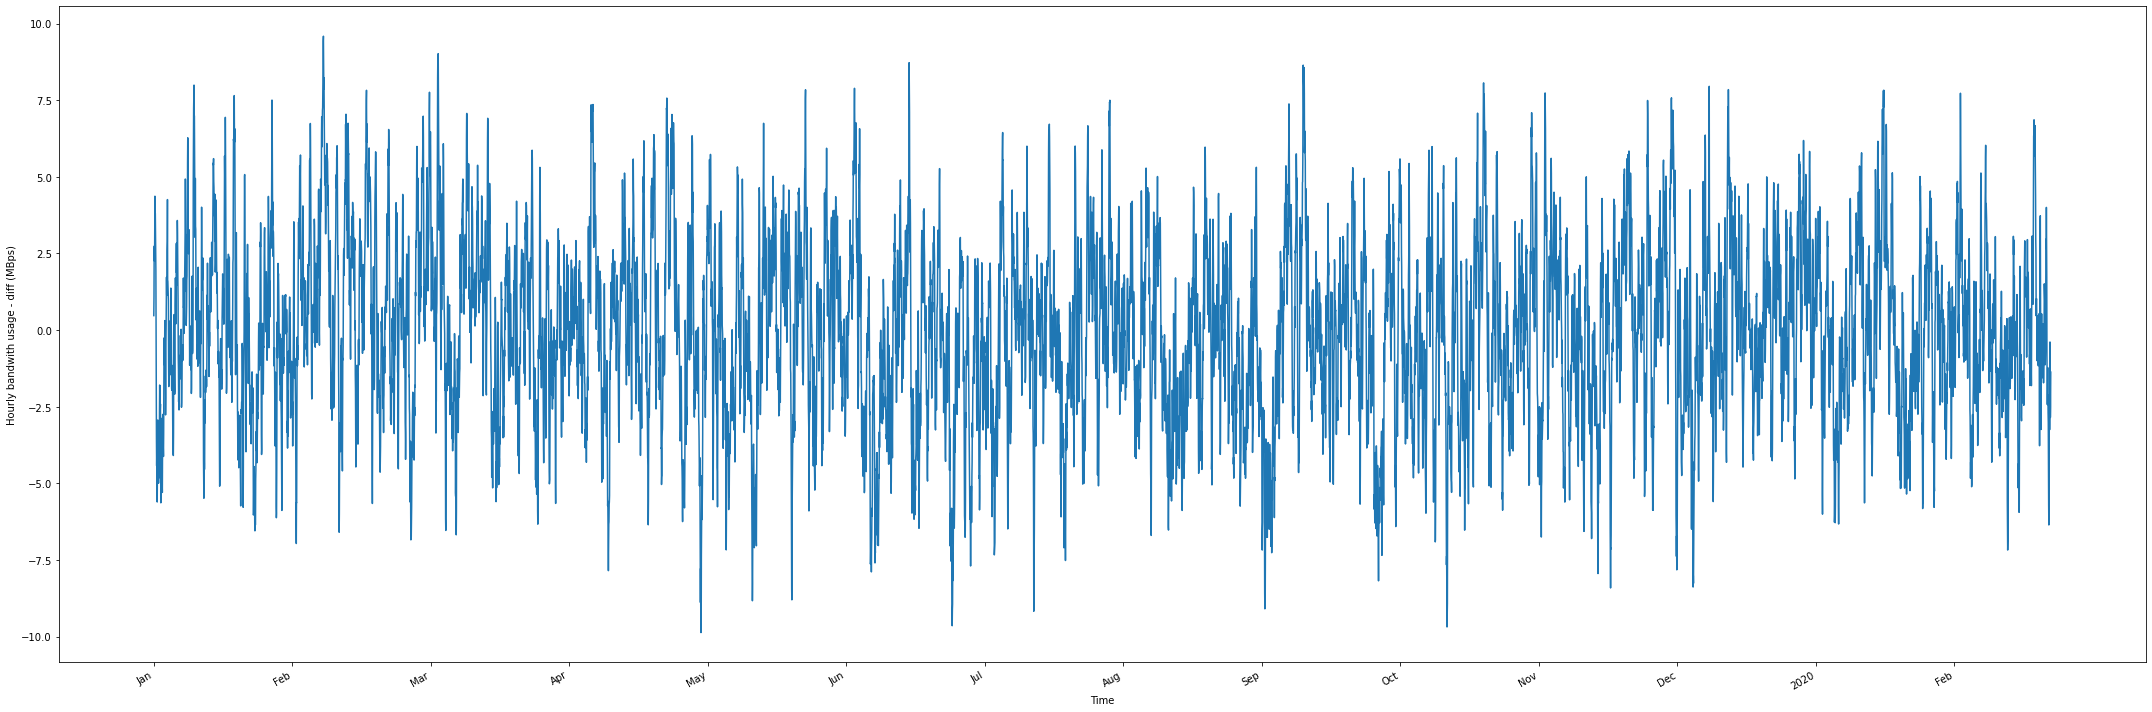

In [29]:
fig, ax = plt.subplots(figsize = (30,10))

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [30]:
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789007
p-value: 0.0


The series is now stationary!

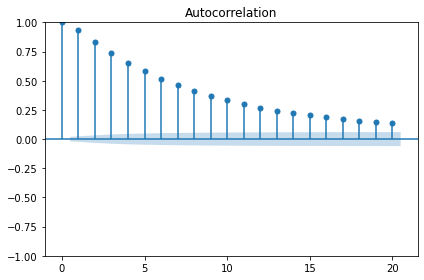

In [31]:
plot_acf(bandwidth_diff, lags=20);

plt.tight_layout()

From the ACF plot we can see that we have no significant lags after lag 0. So we do not have an MA process.

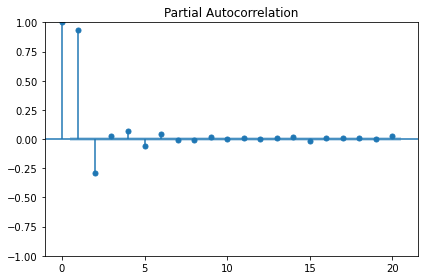

In [32]:
plot_pacf(bandwidth_diff, lags=20);

plt.tight_layout()

From the PACF we also cannot derive a value for p. So we may not have an AR process for this data

Since there is no clear cutoff between significant and non-significant coefficients in both the ACF and PACF plots, we can conclude that we have an ARMA(p,q) process, which is indeed the case.We know that determining the order of our process is key in modeling and forecasting, since the order will dictate how many parameters must be included in our model. Since the ACF and PACF plots are not useful in the case of an ARMA(p,q) process, we must thus devise a general modeling procedure that will allow us to find the appropriate combination of (p,q) for our model.

## **General Modeling Procedure**

This procedure will have the advantage that it can also be applied in situations where our time series is non-stationary and has seasonal effects. Furthermore, it will also be suitable for cases where p or q are equal to 0, meaning that we can move away from plotting the ACF and PACF and rely entirely on a model selection criterion and residual analysis. we can compute the Akaike information criterion (AIC), which is quantifies the quality of each model in relation to each other. The model with the lowest AIC is then selected.
From there, we can analyze the model’s residuals, which is the difference between the actual and predicted values of the model. Ideally, the residuals will look like white noise, which would mean that any difference between the predicted values and actual values is due to randomness. Therefore, the residuals must be uncorrelated and independently distributed. We can assess those properties by studying the quantile-quantile plot (Q-Q plot) and running the Ljung-Box test.

The AIC estimates the quality of a model relative to other models. Given that there will be some information lost when a model is fitted to the data, the AIC quantifies the  relative amount of information lost by the model. The less information lost, the lower the AIC value and the better the model.

In [33]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


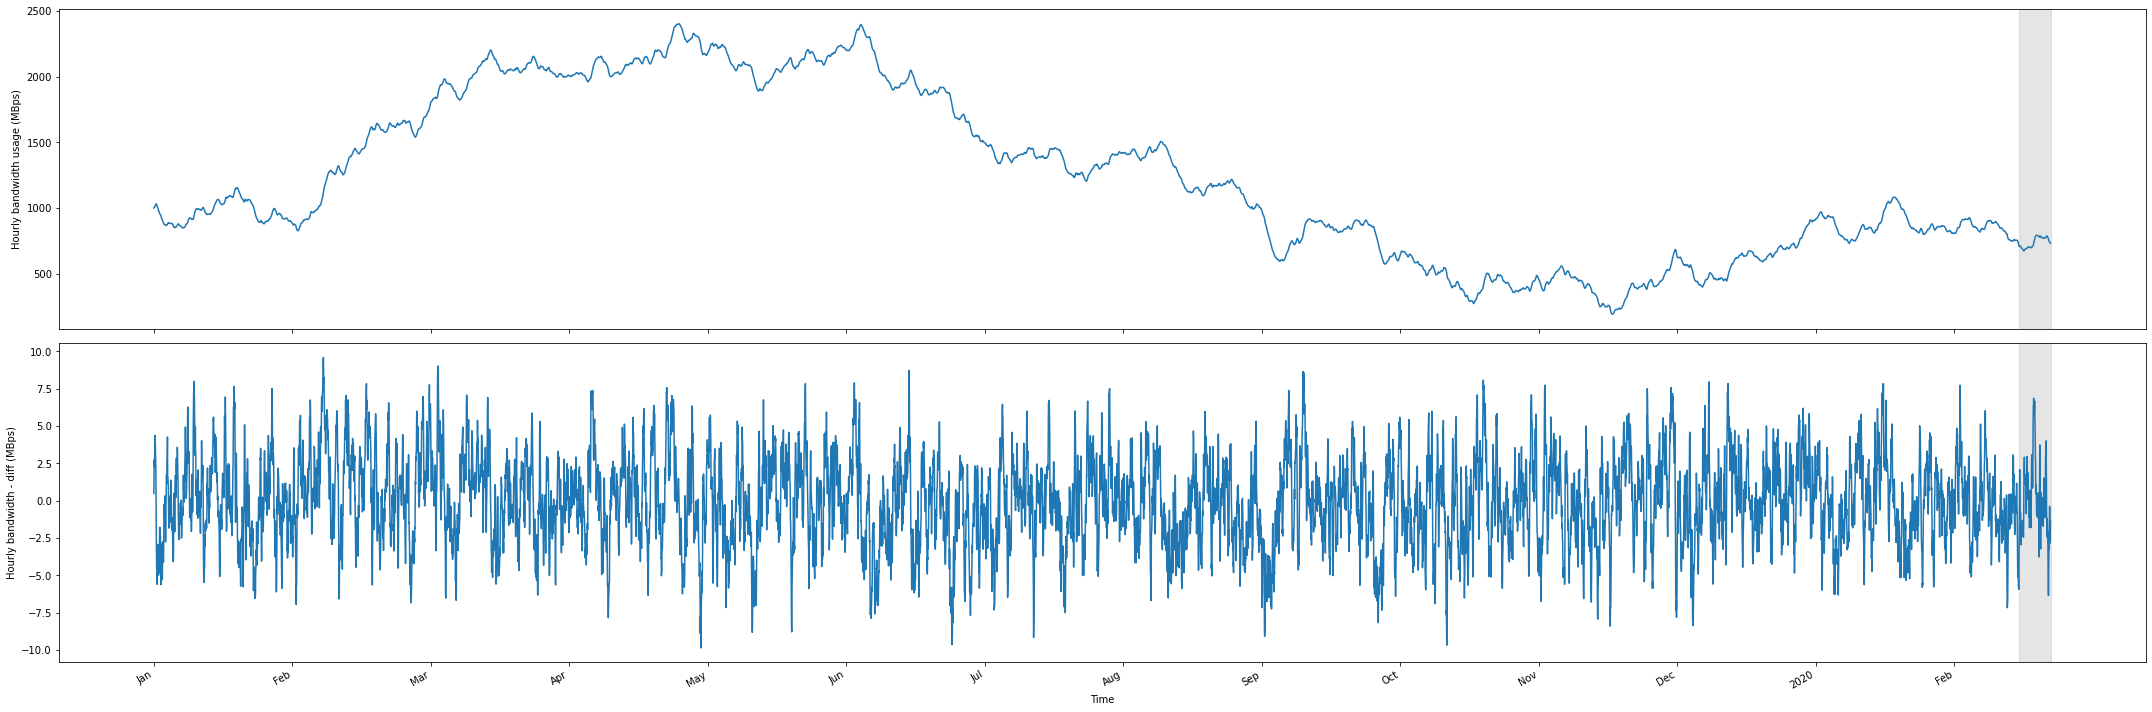

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(30, 10))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [35]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1 ## For this scenario we have only differenciated once

order_list = list(product(ps, qs))

In [36]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d:int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [37]:
result_df = optimize_ARIMA(train, order_list, d)

result_df

C:\Users\raimu\AppData\Local\Temp\ipykernel_54584\4183085313.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",27993.811542
1,"(2, 3)",27994.200200
2,"(1, 3)",28053.519125
3,"(3, 2)",28074.552452
4,"(2, 2)",28099.583303
5,"(2, 1)",28100.580800
6,"(0, 3)",28448.280123
7,"(3, 1)",28455.113866
8,"(3, 0)",28472.403659
9,"(1, 2)",28536.123216


For this scenario the beste choice is an ARMA (3,1,3)

## **Performing residual analysis**

Up to this point we have used a custom function to dinf the combination of parameters with the lowest AIC score. However two additional questions need to be answered regarding the QQ plot and the residuals.

 - Does the Q-Q plot show a straight line? (a graphical tool for verifying our hypothesis that the model’s residuals are normally distributed)
 
 - Are the residuals uncorrelated? (The residuals of a model are simply the difference between the predicted values and the actual values)
 
If both answeres are Yes then we have a model that’s ready to make forecasts. Otherwise, we must try different combinations of (p,q) and restart the process. We have two analysis here a qualitative analysis and a quantitativeanalysis. The qualitative analysis focuses on studying the Q-Q plot, while the quantitative analysis determines whether our residuals are uncorrelated

**So we first fit the model**

In [38]:
model = SARIMAX(train, order=(3,1,3), simple_differencing=False)

model_fit = model.fit(disp=False)

residuals = model_fit.resid

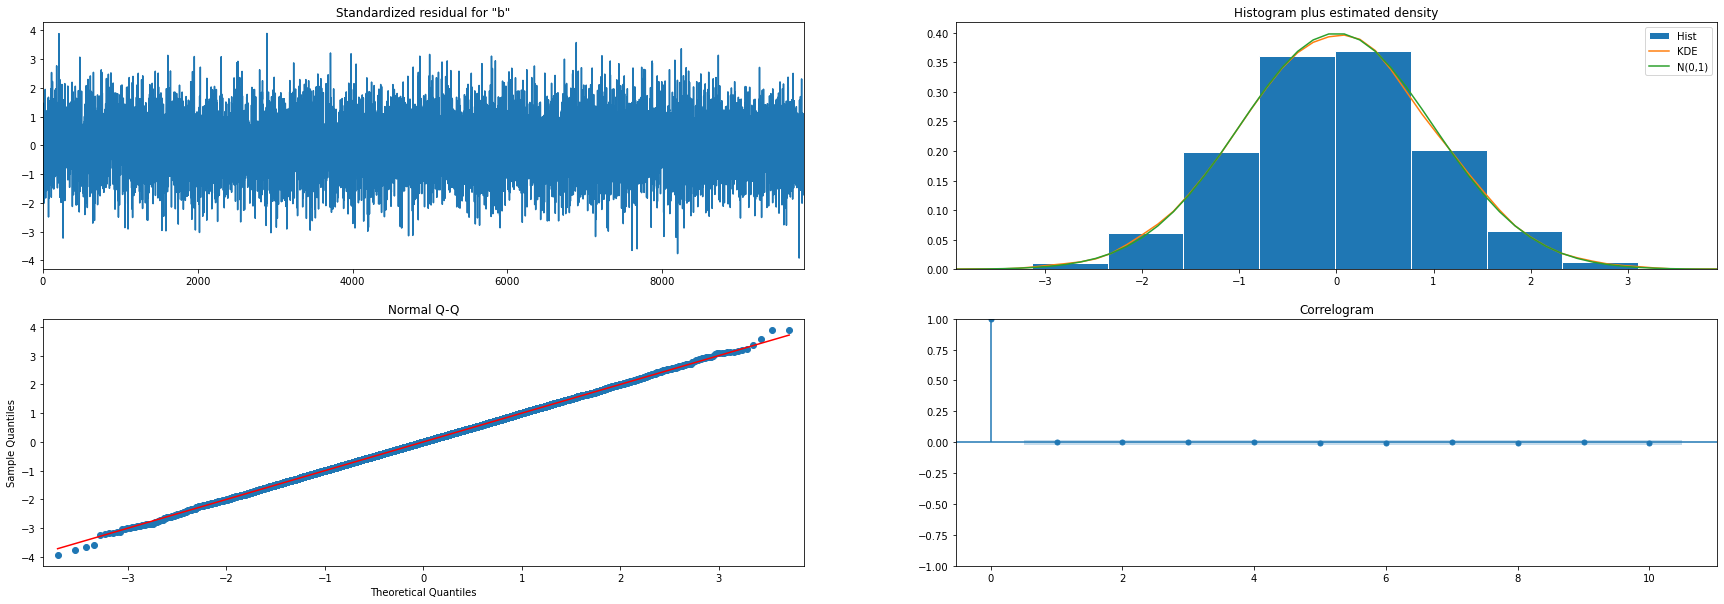

In [39]:
model_fit.plot_diagnostics(figsize=(30, 10))

plt.show()

- The top-left plot shows the residuals across the entire dataset. You can see that there is no trend, and the mean seems stable over time, which is indicative of stationarity, just like white noise.
- The top-right plot shows a histogram of the residuals. You can see the shape of a normal distribution on this plot, which again indicates that the residuals are close to white noise, as white noise is normally distributed as well.
- At the bottom left, we have the Q-Q plot, where the data fits quite well;
- Finally, the bottom-right plot shows the autocorrelation function of our residuals. You can see that there is only a significant peak at lag 0, and no significant coefficients otherwise. This means that the residuals are not correlated, which further supports the conclusion that they are similar to white noise, which is what we expect from a good model.

The final step in residual analysis is applying the Ljung-Box test. This allows us to quantitatively assess whether our residuals are indeed uncorrelated. Our hypothesis are:

- H0: The residuals are independently distributed.
- H1: The residuals are not independently distributed; they exhibit serial correlation.

In [40]:
acorr_ljungbox(residuals, lags = 10)

,lb_stat,lb_pvalue
1,0.000349,0.985102
2,0.015212,0.992423
3,0.053615,0.996751
4,0.079338,0.999234
5,0.289771,0.997831
6,0.339112,0.999284
7,0.434770,0.999652
8,1.359327,0.994805
9,1.381657,0.997933
10,1.902726,0.997033


The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, the null hypothesis cannot be rejected, meaning that the residuals are independently distributed and uncorrelated. So we are ready for modeling!

Same three approaches as before:

- Mean approach;
- Last value Approach;
- ARIMA (3,1,3)

In [41]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [42]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_ARIMA
9831,-5.943995,-0.028214,-5.791207,-5.455499
9832,-5.865194,-0.028214,-5.791207,-4.886659
9833,-3.197066,-0.029410,-5.865194,-5.349623
9834,-1.090197,-0.029410,-5.865194,-4.778676
9835,0.665291,-0.029840,-1.090197,-0.410147


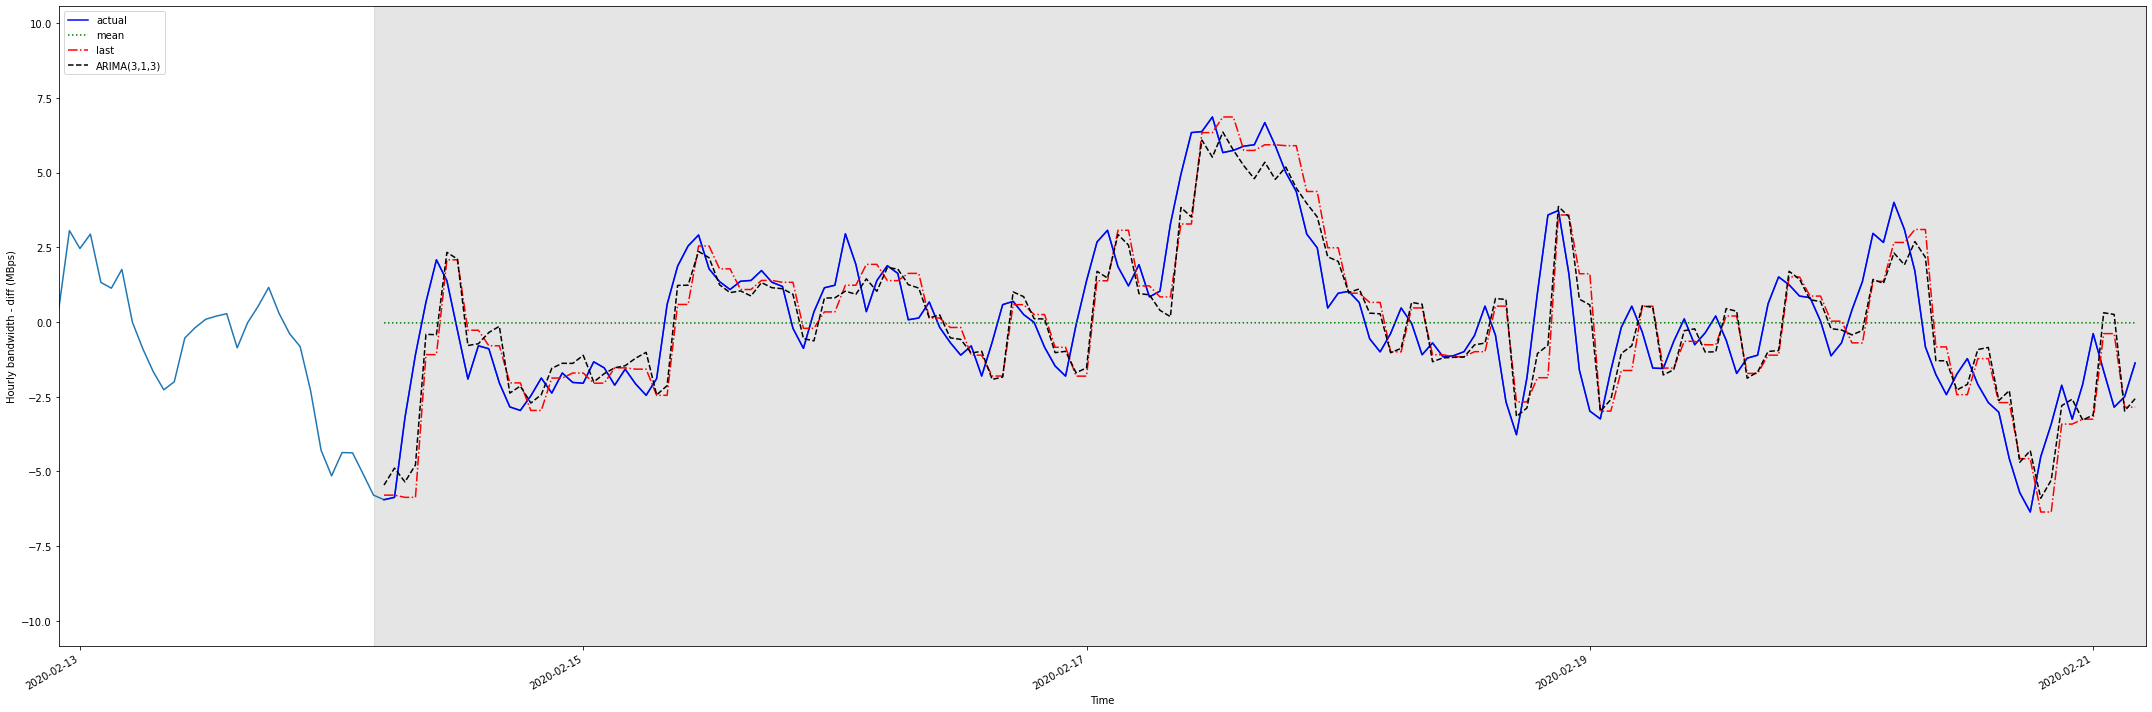

In [43]:
fig, ax = plt.subplots(figsize = (30,10))

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARIMA'], 'k--', label='ARIMA(3,1,3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

We can see that the ARIMA(3,1,3) forecasts, shown as a dashed line, almost coincide with the actual values of the test set. The same can be said of the forecasts from the last known value method, shown as a dashed and dotted line. Of course, the forecasts using the mean, shown as a dotted line, are completely flat over the testing period

In [44]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARIMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARIMA'])

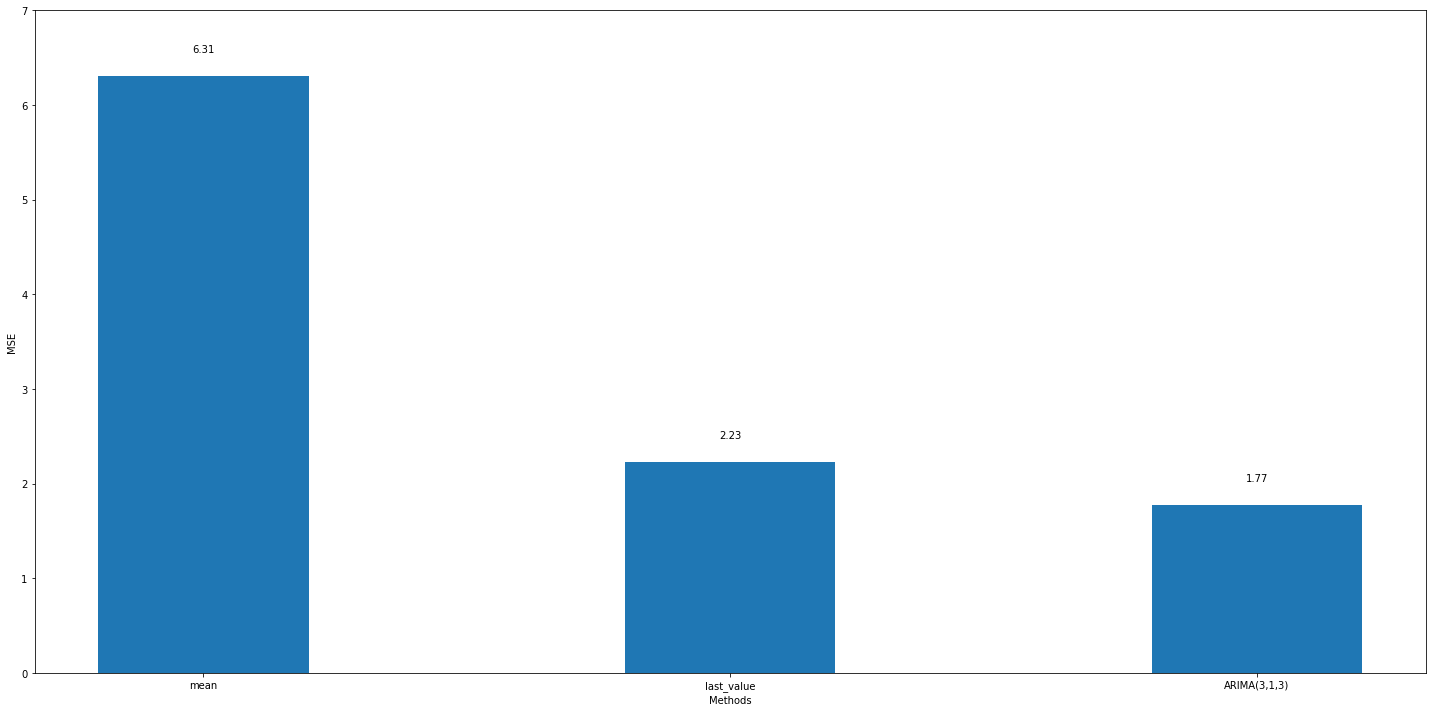

In [46]:
fig, ax = plt.subplots(figsize = (20,10))

x = ['mean', 'last_value', 'ARIMA(3,1,3)']
y = [mse_mean, mse_last, mse_ARIMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

This returns an MSE of 6.3 for the mean method, 2.2 for the last known value method, and 1.8 for the ARMA(3,2) model. The ARMA(3,2) model outperforms the benchmarks, meaning that we have a well-performing model.

The final step is to reverse the transformation of our forecast in order to bring it to the same scale as our original data. Remember that we differenced the original data to make it stationary. The ARMA(2,2) model was then applied on the stationary dataset and produced forecasts that are differenced.

In [48]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARIMA'].cumsum()

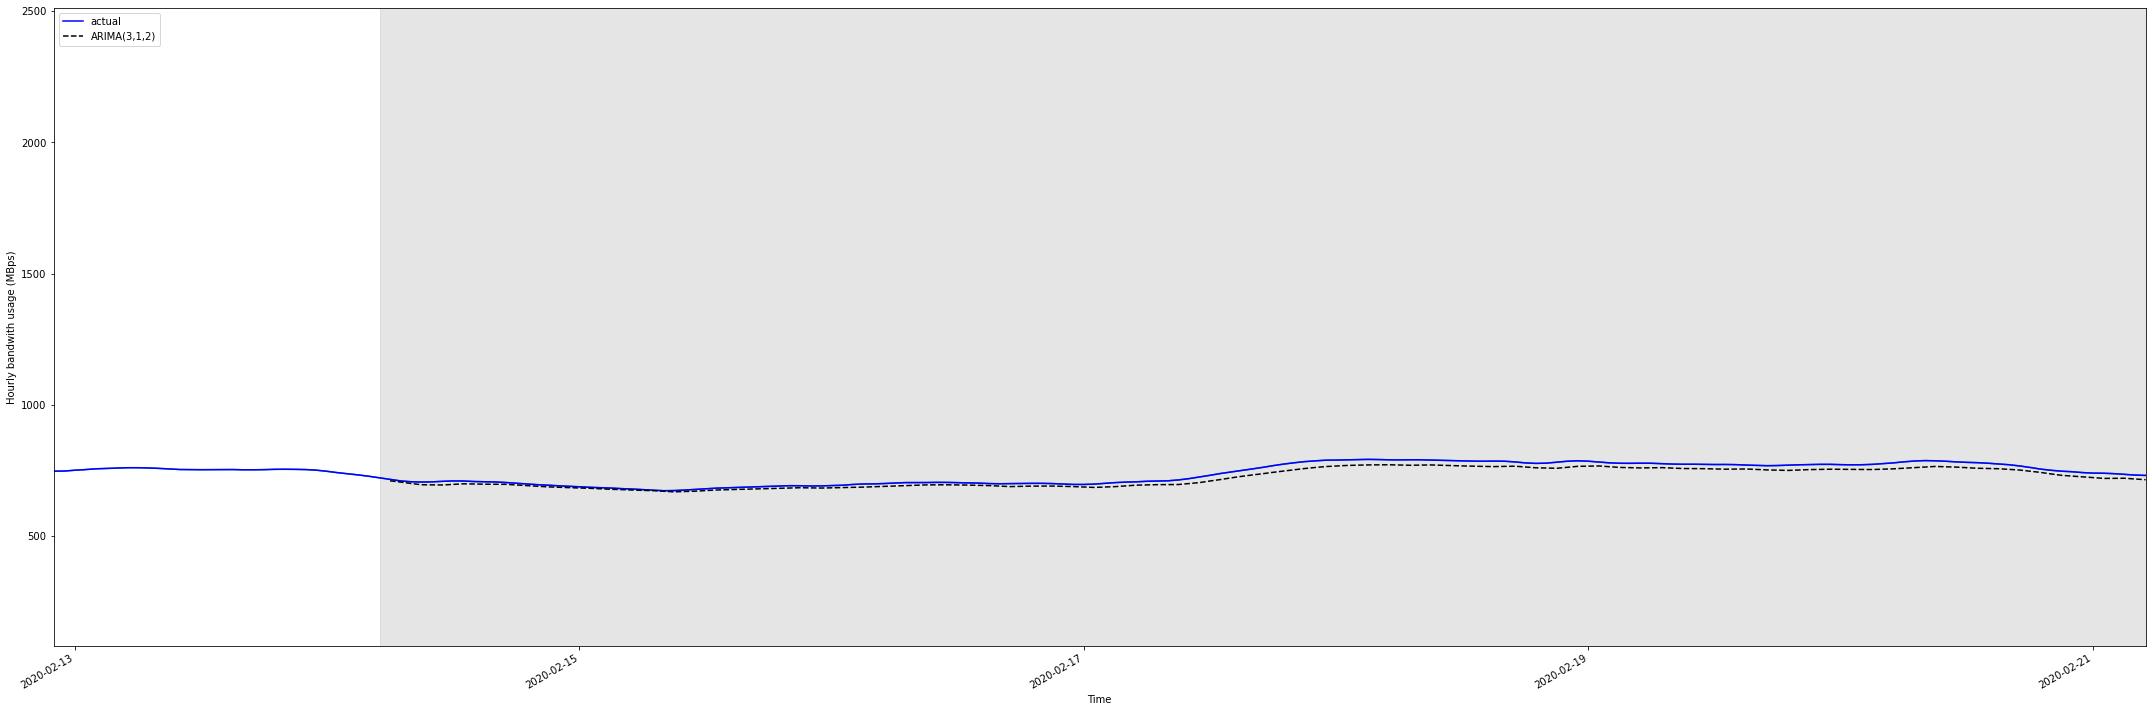

In [49]:
fig, ax = plt.subplots(figsize = (30,10))

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARIMA(3,1,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

Looking at the results in figure 6.20, you can see that our forecasts, shown as a dashed line, closely follow the actual values of the test set, and the two lines almost coincide.

In [51]:
mae_ARIMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARIMA_undiff)

14.473573972776194
